##**SHETH L.U.J. COLLEGE OF ARTS & SIR M.V. COLLEGE OF SCIENCE & COMMERCE**

**Aim: Adaboost Ensemble Learning**
* Implement the Adaboost algorithm to create an ensemble of weak classifiers.
* Train the ensemble model on a given dataset and evaluate its performance.
* Compare the results with individual weak classifiers.




### **Bhumika Shelar | T114**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import  accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
df = pd.read_csv("/content/social_media_engagement1.csv")
df.shape

(100, 9)

In [ ]:
df.head()

,post_id,platform,post_type,post_time,likes,comments,shares,post_day,sentiment_score
0,1,Facebook,image,8/17/2023 14:45,2121,474,628,Thursday,positive
1,2,Facebook,carousel,5/14/2023 0:45,3660,432,694,Sunday,neutral
2,3,Instagram,poll,2/21/2023 16:15,4955,408,688,Tuesday,negative
3,4,Twitter,image,11/16/2023 0:45,1183,90,187,Thursday,negative
4,5,Twitter,video,5/23/2023 0:30,3499,247,286,Tuesday,positive


In [ ]:
# Encode categorical features
df['platform'] = df['platform'].astype('category').cat.codes
df['post_type'] = df['post_type'].astype('category').cat.codes
X = df.drop(['post_id', 'post_day', 'sentiment_score'], axis=1).values  # Feature matrix
y = np.where(df['sentiment_score'] == 'positive', 1, -1)   # Label vector: positive → 1, others → -1

In [ ]:
# Set Features and Label
X = df.drop(['post_id', 'sentiment_score', 'post_day'], axis=1)
X = X.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col)

y = df['sentiment_score']

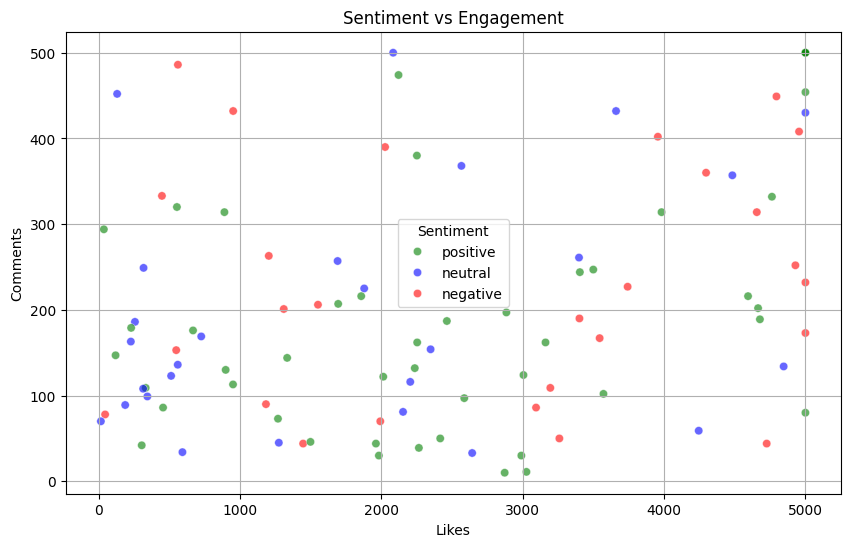

In [ ]:
# Scatter plot: Likes vs Comments, colored by Sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='likes',
    y='comments',
    hue='sentiment_score',
    palette={'positive': 'green', 'neutral': 'blue', 'negative': 'red'},
    alpha=0.6
)

plt.title('Sentiment vs Engagement')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

In [ ]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
#Train Weak Classifier
n_train = X_train.shape[0]
T = 50  # number of weak classifier
weights = np.full(n_train, 1 / n_train)
learners = []
learner_weights = []

In [ ]:
for t in range(T):
    # Sample training data based on weights
    sample_idx = np.random.choice(n_train, size=n_train, p=weights)
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # Train weak learner (decision stump)
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_sample, y_sample)
    pred = stump.predict(X_train)

    # Compute weighted error
    miss = (pred != y_train)
    err = np.dot(weights, miss)
    err = np.clip(err, 1e-10, 1 - 1e-10)

    # Compute alpha (learner weight)
    alpha = 0.5 * np.log((1 - err) / err)

    # Update weights
    weights *= np.exp(-alpha * y_train * pred)
    weights /= np.sum(weights)

    # Save learner and weight
    learners.append(stump)
    learner_weights.append(alpha)

In [ ]:
# Prediction on test set
def predict(X):
    clf_preds = np.array([alpha * clf.predict(X) for clf, alpha in zip(learners, learner_weights)])
    y_pred = np.sign(np.sum(clf_preds, axis=0))
    return y_pred

y_pred = predict(X_test)

Accuracy: 0.6


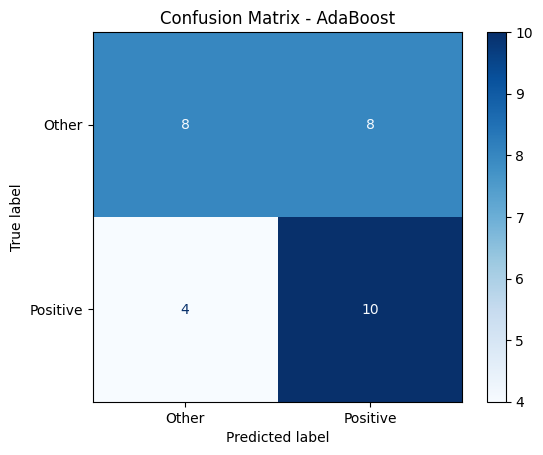

In [ ]:
# Convert y_test to binary: positive → 1, others → -1
y_test_bin = np.where(df.loc[y_test.index, 'sentiment_score'] == 'positive', 1, -1)

# Make AdaBoost predictions using weighted majority vote
final_pred = np.zeros(len(X_test))
for alpha, stump in zip(learner_weights, learners):
    final_pred += alpha * stump.predict(X_test)
y_pred = np.sign(final_pred)

# Accuracy
print("Accuracy:", accuracy_score(y_test_bin, y_pred))

# Confusion matrix
cm = confusion_matrix((y_test_bin == 1), (y_pred == 1))  # Boolean to 0/1
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - AdaBoost")
plt.show()